In [2]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
import time
import zipfile
import os




In [3]:

import collections
import numpy as np
import pandas as pd

import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor



data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

## Loading dataset

In [4]:
dataset = dgl.data.CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [5]:
g = dataset[0]
print(g)

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})


## Training

## Base Model for CoraGraphDataset

In [6]:
# Create the model with given dimensions
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.conv3 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = F.dropout(h, p=0.3, training=self.training)
        h = self.conv3(g,h)
        
        return h
    
    
model = GCN(g.ndata["feat"].shape[1], 16, dataset.num_classes)# the number pf hidden_channels=16
model

GCN(
  (conv1): GraphConv(in=1433, out=16, normalization=both, activation=None)
  (conv2): GraphConv(in=16, out=16, normalization=both, activation=None)
  (conv3): GraphConv(in=16, out=7, normalization=both, activation=None)
)

#### We want to estimate the times of learning process, and size of basemodel with and  without Zip before and after pruning. So we define the next two functions. 
  

In [11]:
import torch

from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def train(g, model, num_epoch):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_trn_acc = 0
    train_hist, valid_hist = [], []

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]
    
    for e in range(num_epoch):
      
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        trn_loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        val_loss = F.cross_entropy(logits[val_mask], labels[val_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        #test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        
        train_hist += [(trn_loss.detach().item(), train_acc)]
        valid_hist += [(val_loss.detach().item(), val_acc)]

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            
       
        if best_trn_acc < train_acc:
            best_trn_acc = train_acc
            
        
        # Backward
        optimizer.zero_grad()
        trn_loss.backward()
        optimizer.step()

        if e % 20 == 0:
            print(
                f"In epoch {e}, Training Loss: {trn_loss:.3f}, Training Acc: {train_acc:.3f} (best_trn_acc {best_trn_acc:.3f}), val_acc: {val_acc:.3f} (best_val_acc {best_val_acc:.3f})"
            )
      
    return train_hist, valid_hist,best_val_acc 





def get_gzipped_model_size(file , zip_name):
    '''
    The get_gzipped_model_size function is designed to compress a file into a zip archive using
    the ZIP_DEFLATED compression method and then return the size of the resulting zip file
    '''
    
    with zipfile.ZipFile(zip_name, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
        
    return os.path.getsize(zip_name)

In [15]:
def test(g):
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    test_mask = g.ndata["test_mask"]
    model.eval()
    # Forward
    logits = model(g, features)
    # Compute prediction
    pred = logits.argmax(1)
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
    return test_acc
 
    

In [10]:


def factors(model , model_name , zip_name, num_epoch):
    '''
    The outputs of this function are 
    -the times of learning process,
    -Size of basemodel with and  without Zip, 
    -and the values of loss and accuracy in train and valid set.
    '''
    start = datetime.now()
    train_hist, valid_hist, model_accuracy=train(g, model, num_epoch)
    end = datetime.now()
    
    t = end-start
    
    torch.save(model.state_dict, model_name)
    
    size_without_zip = os.path.getsize(model_name)
    
    size_with_zip = get_gzipped_model_size(model_name , zip_name)
    
    return t.total_seconds(), size_without_zip , size_with_zip, model_accuracy,train_hist, valid_hist

In [12]:

num_epoch=100
time_0, size_without_zip_0 ,size_with_zip_0, model_accuracy_0,train_hist_0, valid_hist_0 = factors(model , 'model.pickle' ,'Base Model.zip',num_epoch)

name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,model_accuracy_0) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_0 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_0 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_0, 'sec')

In epoch 0, Training Loss: 1.946, Training Acc: 0.107 (best_trn_acc 0.107), val_acc: 0.138 (best_val_acc 0.138)
In epoch 20, Training Loss: 1.615, Training Acc: 0.671 (best_trn_acc 0.671), val_acc: 0.478 (best_val_acc 0.478)
In epoch 40, Training Loss: 0.790, Training Acc: 0.857 (best_trn_acc 0.857), val_acc: 0.550 (best_val_acc 0.550)
In epoch 60, Training Loss: 0.295, Training Acc: 0.957 (best_trn_acc 0.964), val_acc: 0.680 (best_val_acc 0.710)
In epoch 80, Training Loss: 0.110, Training Acc: 0.993 (best_trn_acc 0.993), val_acc: 0.676 (best_val_acc 0.728)
Accuracy of basemodel is :0.73 %
Size of basemodel without Zip is : 96263 Bytes
Size of basemodel with Zip is : 87948 Bytes
Time taken for evaluating basemodel is : 7.363838 sec


### Let's plot model loss and accuracy

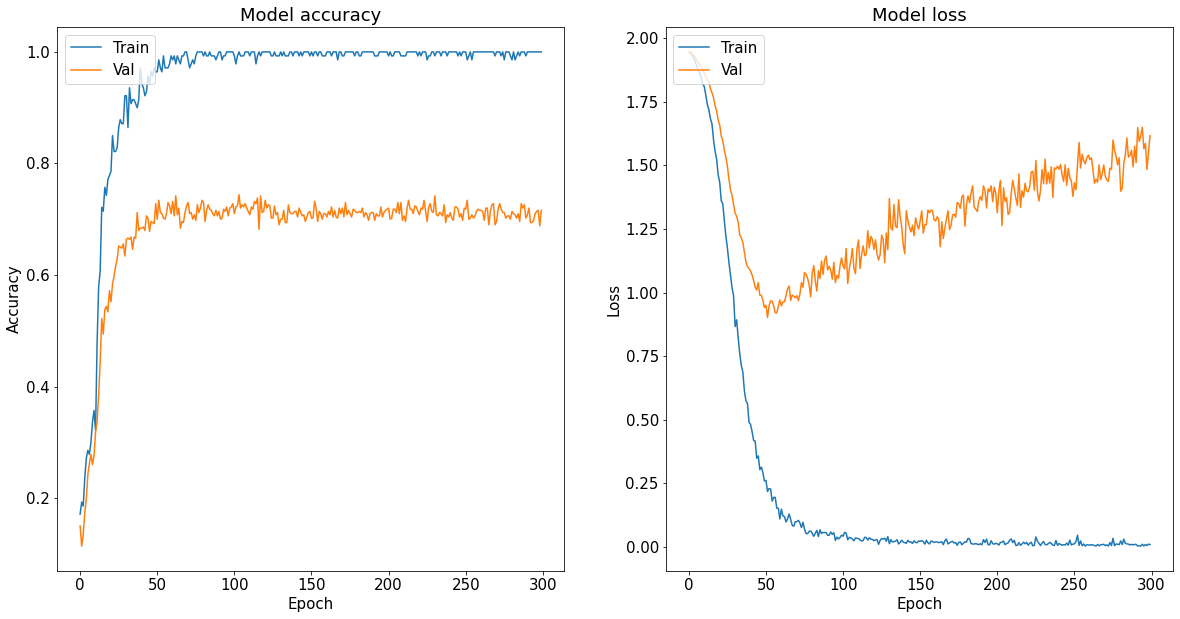

In [17]:
eva(train_hist_0,valid_hist_0)

In [18]:
test_loss, test_acc=evaluate_model(model,g)
# Print the metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')
#print(f'Test F1-score: {test_f1:.4f}')

Test loss: 1.2372
Test accuracy: 0.7370


In [ ]:
##

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    #he visualize function uses the TSNE class to reduce the dimensionality of the input h to 2 dimensions,
    #and then plots the resulting 2D points using pyplot.scatter.
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


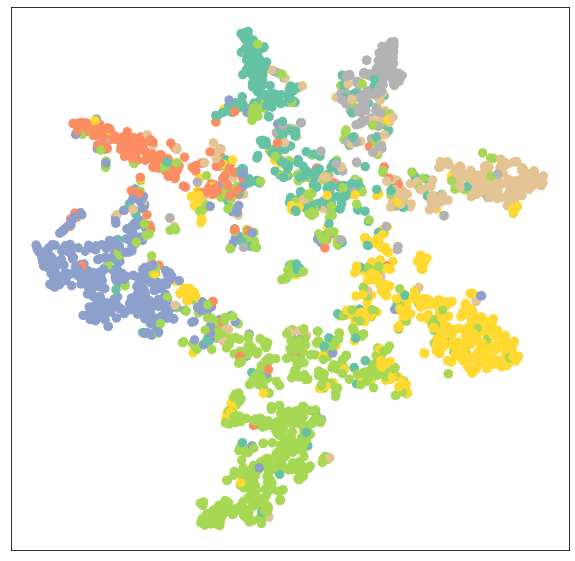

In [16]:

model.eval()

# This is important because during training, the model may use techniques like dropout or
# batch normalization which are not used during evaluation.
out = model(g, g.ndata["feat"])

visualize(out , color=g.ndata["label"])

##  Measurement of avarage of accuracy, and time inference

In [ ]:
import time
import statistics as stat


Eva_final=dict()


Base_model_Acc=[]
T_base_model=[]


In [ ]:

for i in range(10):


        model = GCN(dataset.num_features, dataset.num_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        

        num_epoch=100
        time, size_without_zip ,size_with_zip, model_accuracy,train_hist, valid_hist = factors(model , 'model.pickle' ,'Base Model.zip',num_epoch)

        name = 'basemodel'

        start = time.time()
        test_acc = test(g)
        end = time.time()
        t_inference= end-start

        print(f"Train Accuracy: {model_accuracy}, Test Accuracy: {test_acc}, Time inference:{t_inference}")
        print('Size of %s without Zip is :' % (name) , size_without_zip ,'Bytes')
        print('Size of %s with Zip is :' % (name), size_with_zip ,'Bytes')
        print('Time taken for evaluating %s is :' % (name) ,time, 'sec')


        Base_model_Acc.append(test_acc)
        T_base_model.append(t_inference)

In [ ]:
print(f'Base_model_Acc in ten time:')
print ("{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<15}|{:<20}"\
    .format(Base_model_Acc[0],Base_model_Acc[1],Base_model_Acc[2],\
        Base_model_Acc[3],Base_model_Acc[4],Base_model_Acc[5],\
        Base_model_Acc[6],Base_model_Acc[7],Base_model_Acc[8],Base_model_Acc[9]))
print ("-"*110)
print(f'Time Inference model in ten time:')
#print(T_base_model)
print ("{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<10}|{:<15}|{:<20}"\
    .format(T_base_model[0],T_base_model[1],T_base_model[2],\
        T_base_model[3],T_base_model[4],T_base_model[5],\
        T_base_model[6],T_base_model[7],T_base_model[8],T_base_model[9]))

In [ ]:
import statistics as stat

base_model_accuracy_mean = stat.mean(Base_model_Acc)
base_model_accuracy_std =  stat.stdev(Base_model_Acc)
desc_auc = "{:.3f} ± {:.3f}".format(base_model_accuracy_mean,base_model_accuracy_std)
print(f"Auc: {desc_auc}"  )

Eva_final.update({'base model accuracy':float(format(base_model_accuracy_mean, '.4f'))})

t_base_model_mean =stat.mean(T_base_model)
t_base_model_std =stat.stdev(T_base_model)
desc_T = "{:.3f} ± {:.3f}".format(t_base_model_mean,t_base_model_std)

print(f"Time inference :{desc_T}")
Eva_final.update({'time inference of base model':float(format(t_base_model_mean, '.6f'))})

In [ ]:
def get_num_parameters(model, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width


print(f"Model Size: {get_model_size(model)}")